### Naive predictions and Random Forest Baseline

For a baseline model, this notebook implements:
- Naive method of forecasting where it uses the most recent newarrival available
- RandomForest method, simply considering the data basically as cross-sectional data.

In [597]:
import numpy as np
import pandas as pd

data = pd.read_csv('../../data/data.csv', engine='pyarrow').drop_duplicates(subset=['Id','year']).drop(['Country_o','Country_d','iso_d','iso_o', ''], axis=1)

#### Preprocessing

In [598]:
# filter out missing data
data = data[data.year < 2022]

# there are some countries that are contiguous but aren't marked as so. this corrects that
data[data.Id.isin(['SSDETH', 'ETHSSD','SSDUGA','UGASSD','CODUGA','UGACOD','SSNSSD','SSDSSN','CODCOG','COGCOD'])].contig = 1

# all observations must have at least one value greater than c
c = 100
#data = data.groupby('Id', as_index=False).filter(lambda x: x['newarrival'].max() > c)

data['year'] = pd.to_datetime(data['year'], format='%Y')
data = data.set_index(['year', 'Id'])
data.index.levels[1].freq = "Y"
#data = data['y']
data = data.sort_index()

/var/folders/hs/1r2tlf751_l1nl8n9l2_wtpw0000gn/T/ipykernel_43455/720787505.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data.Id.isin(['SSDETH', 'ETHSSD','SSDUGA','UGASSD','CODUGA','UGACOD','SSNSSD','SSDSSN','CODCOG','COGCOD'])].contig = 1


Specify train and test sets:

In [599]:
end_train = '2016-01-01'
end_val = '2016-01-01'

data_train = data.loc[:end_train, :].copy()
# data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_val:, :].copy()

#### Naive method- Baseline approach

In [667]:
def filter_multi(df,col,val):
    col_index = pd.Series(df.index.names)[(pd.Series(df.index.names) == col)].index.tolist()[0]
    if val is type(str):
        return np.in1d(df.index.get_level_values(col_index), [val])
    else:
        return pd.Series(df.index.get_level_values(col_index)).isin(val).values
    
import operator
def filter_multi_date(df,col,val, relate):
    ops = {'>': operator.gt,
        '<': operator.lt,
        '>=': operator.ge,
        '<=': operator.le,
        '==': operator.eq}
    col_index = pd.Series(df.index.names)[(pd.Series(df.index.names) == col)].index.tolist()[0]
    return ops[relate](df.index.get_level_values(col_index),  pd.to_datetime(val))

In [47]:
# naive prediction
def naive_prediction(series, h):
    last_val = series.iloc[-1]
    pred =  np.repeat(last_val, h)
    return pred

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

# rolling window rmse
def rolling_rmse(series, window_len, h):
    series_len = len(series)
    n_of_forecasts = (series_len - (window_len + h) + 1)

    if n_of_forecasts < 1:
        raise ValueError
    
    errors = np.array([])
    errors.shape = (0, h)

    for i in range(n_of_forecasts):
        window = series.iloc[i:(i + window_len)]
        forecast = naive_prediction(window, h)
        actual = series[(i + window_len):(i + window_len + h)].values
        
        rmse_error = ((forecast - actual)**2)**.5
        errors = np.vstack([errors, rmse_error])

    return pd.DataFrame(errors, columns = np.array([*range(h)])+1).melt(var_name='horizon',value_name='naive')

# rolling window predictions
def rolling_prediction(series, window_len, h):
    series_len = len(series)
    
    n_of_forecasts = (series_len - (window_len + h) + 1)
    
    if n_of_forecasts < 1:
        raise ValueError
    
    errors = np.array([])
    errors.shape = (0, h)

    actual = []
    forecast = []

    for i in range(n_of_forecasts):
        window = series.iloc[i:(i + window_len)]
        forecast.append(naive_prediction(window, h)[0])
        actual.append(series[(i + window_len):(i + window_len + h)].values[0])

    return pd.DataFrame({'pred':forecast,'actual':actual})

Text(0, 0.5, 'New arrivals')

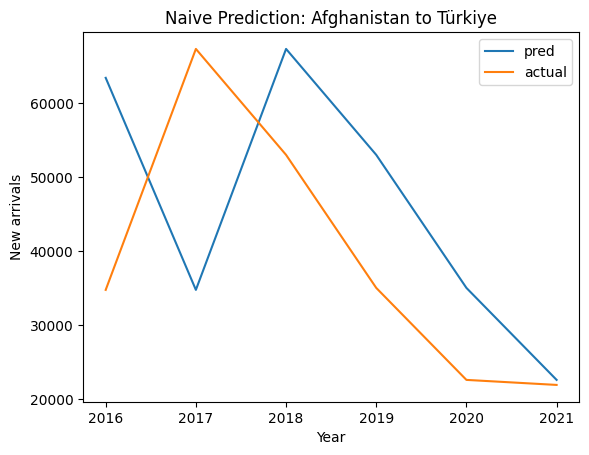

In [33]:
ax = data[filter_multi(data, 'Id',['AFGTUR']) & filter_multi_date(data, 'year','2015','>=')].groupby('Id').newarrival.apply(lambda x: rolling_prediction(x, 1,1)).reset_index().drop(['Id','level_1'],axis=1)
ax.index = pd.Series([*range(2016, 2022)]).astype(str)
ax = ax.plot.line(title='Naive Prediction: Afghanistan to Türkiye')
ax.set_xlabel("Year")
ax.set_ylabel("New arrivals")

In [49]:
# serial
naive_metrics = data[filter_multi_date(data, 'year','2015','>=')].newarrival.groupby(level='Id').apply(lambda x:rolling_rmse(x, 1, 1)).groupby('horizon').mean()
naive_metrics

,naive
horizon,
1,79.249525


#### RF Baseline

In [601]:
def multi_shift(df, shift_range, columns):
    shifted_data = []
    for shift_value in range(shift_range.start, shift_range.stop):
        shifted = df[columns].shift(shift_value)
        shifted_data.append(shifted)
    shifted_df = pd.concat(shifted_data, axis=1, keys=[f'Shift_{shift_value}' for shift_value in range(shift_range.start, shift_range.stop)])
    shifted_df.columns = [' '.join(col).strip() for col in shifted_df.columns.values]
    return pd.concat([df, shifted_df],axis=1).dropna()

In [830]:
lagged_data.loc[filter_multi(lagged_data, 'Id',['AFGTUR']), lagged_data.columns[pd.Series(lagged_data.columns).str.contains('Shift') | pd.Series(lagged_data.columns).isin(['newarrival','dead_log_o']) ]]

dead_log_o  newarrival  Shift_1 newarrival   
Id     year                                                     
AFGTUR 2004-01-01       6.741     341.000              77.000  \
       2005-01-01       7.498     364.000             341.000   
       2006-01-01       8.510     261.000             364.000   
       2007-01-01       8.852     705.000             261.000   
       2008-01-01       8.666    2788.000             705.000   
       2009-01-01       8.800    1653.000            2788.000   
       2010-01-01       8.899    1248.000            1653.000   
       2011-01-01       8.928    2486.000            1248.000   
       2012-01-01       8.967   14146.000            2486.000   
       2013-01-01       9.078    8726.000           14146.000   
       2014-01-01       9.932   15652.000            8726.000   
       2015-01-01       9.861   63443.000           15652.000   
       2016-01-01      10.067   34775.000           63443.000   
       2017-01-01      10.394   67352.000           34775.000   
       2018-01-01      10.391   53029.000           67352.000   
       2019-01-01      10.426   35042.000           53029.000   
       2020-01-01      10.074   22606.000           35042.000   
       2021-01-01      10.074   21926.000           22606.000   

                   Shift_1 dead_log_o  Shift_2 newarrival  Shift_2 dead_log_o   
Id     year                                                                     
AFGTUR 2004-01-01               6.872              47.000               5.714  \
       2005-01-01               6.741              77.000               6.872   
       2006-01-01               7.498             341.000               6.741   
       2007-01-01               8.510             364.000               7.498   
       2008-01-01               8.852             261.000               8.510   
       2009-01-01               8.666             705.000               8.852   
       2010-01-01               8.800            2788.000               8.666   
       2011-01-01               8.899            1653.000               8.800   
       2012-01-01               8.928            1248.000               8.899   
       2013-01-01               8.967            2486.000               8.928   
       2014-01-01               9.078           14146.000               8.967   
       2015-01-01               9.932            8726.000               9.078   
       2016-01-01               9.861           15652.000               9.932   
       2017-01-01              10.067           63443.000               9.861   
       2018-01-01              10.394           34775.000              10.067   
       2019-01-01              10.391           67352.000              10.394   
       2020-01-01              10.426           53029.000              10.391   
       2021-01-01              10.074           35042.000              10.426   

                   Shift_3 newarrival  Shift_3 dead_log_o  Shift_4 newarrival   
Id     year                                                                     
AFGTUR 2004-01-01             431.000               8.850              81.000  \
       2005-01-01              47.000               5.714             431.000   
       2006-01-01              77.000               6.872              47.000   
       2007-01-01             341.000               6.741              77.000   
       2008-01-01             364.000               7.498             341.000   
       2009-01-01             261.000               8.510             364.000   
       2010-01-01             705.000               8.852             261.000   
       2011-01-01            2788.000               8.666             705.000   
       2012-01-01            1653.000               8.800            2788.000   
       2013-01-01            1248.000               8.899            1653.000   
       2014-01-01            2486.000               8.928            1248.000   
       2015-01-01           14146.000       

In [602]:
# create lagged features
lagged_data = data.groupby('Id').apply(lambda x: multi_shift(x, range(1,5), ['newarrival','dead_log_o'])).reset_index(level=2,drop=True)

h1 = lagged_data.groupby('Id').newarrival.shift(-1)

In [794]:
# create train and test for x and y
X_train = lagged_data[filter_multi_date(lagged_data, 'year',end_train,'<=')]
y_train = h1[filter_multi_date(h1, 'year',end_train,'<=')]

# omit syria from test evaluation since it has missing data
X_test = lagged_data[filter_multi_date(lagged_data, 'year',end_train,'>')]
X_test = X_test[filter_multi_date(X_test, 'year','2021','<')]
y_test = h1[filter_multi_date(h1,'year',end_train,'>') & filter_multi_date(h1, 'year','2021','<')]

In [610]:
# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [875]:
from sklearn.metrics import mean_squared_error
pred_df = pd.concat([X_test.reset_index()[['Id','year','newarrival']], pd.Series(rf.predict(X_test), name='RF'), pd.Series(y_test, name='actual').reset_index(drop=True)], axis=1)
#pred_df['abs_error'] = pred_df.apply(lambda x: np.abs(x.actual- x.pred), axis=1)

## Proposed Framework Model

### Stage 1: outflow prediction

In [612]:
import numpy as np
import pandas as pd

data_outflows = pd.read_csv('../../data/data.csv', engine='pyarrow').drop_duplicates(subset=['Id','year'])[['iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',
       'island_o', 'area_o', 'landlocked_o', 'PR_o', 'CL_o',
       'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
       'dead_log_o', 'Nyear_conf_o', 'dead_o', 'newarrival']]

# preprocessing
data_outflows = data_outflows[data_outflows.year < 2022]
data_outflows['year'] = pd.to_datetime(data_outflows['year'], format='%Y')
data_outflows = pd.concat([data_outflows.drop('newarrival',axis=1).groupby(['iso_o', 'year']).first(),data_outflows.groupby(['iso_o', 'year']).newarrival.sum()],axis=1)

In [952]:
data_outflows

pop_o   CPI_o  GDP_PP_o  GDP_PPP_o  island_o     area_o   
iso_o year                                                                  
ABW   2000-01-01  0.091   3.544 36636.950      0.005         1    193.000  \
      2001-01-01  0.091   2.518 37813.880      0.006         1    193.000   
      2002-01-01  0.092   4.162 37198.230      0.005         1    193.000   
      2003-01-01  0.093   2.287 37185.650      0.005         1    193.000   
      2004-01-01  0.095   2.774 39054.940      0.005         1    193.000   
...                 ...     ...       ...        ...       ...        ...   
ZWE   2017-01-01 14.437   3.430  2311.530      0.027         0 390759.000   
      2018-01-01 14.642  42.074  2387.040      0.028         0 390759.000   
      2019-01-01 14.905 521.150  2200.740      0.025         0 390759.000   
      2020-01-01 15.189 348.586  2048.270      0.025         0 390759.000   
      2021-01-01 15.492  60.737  2151.970      0.025         0 390759.000   

                  landlocked_o  PR_o  CL_o  typeOfViolence_o  best_est_o   
iso_o year                                                                 
ABW   2000-01-01             0     4     3                 0       0.000  \
      2001-01-01             0     5     4                 0       0.000   
      2002-01-01             0     3     3                 0       0.000   
      2003-01-01             0     3     2                 0       0.000   
      2004-01-01             0     3     3                 0       0.000   
...                        ...   ...   ...               ...         ...   
ZWE   2017-01-01             1     6     5                 0       0.000   
      2018-01-01             1     5     5                 3       4.000   
      2019-01-01             1     5     5                 3       8.000   
      2020-01-01             1     6     5                 3       2.000   
      2021-01-01             1     6     5                 3       2.000   

                  Nyear_conflict_o  Nyear_log_o  dead_log_o  Nyear_conf_o   
iso_o year                                                                  
ABW   2000-01-01             0.000        0.000       0.000             0  \
      2001-01-01             0.000        0.000       0.000             0   
      2002-01-01             0.000        0.000       0.000             0   
      2003-01-01             0.000        0.000       0.000             0   
      2004-01-01             0.000        0.000       0.000             0   
...                            ...          ...         ...           ...   
ZWE   2017-01-01             0.000        0.000       0.000             0   
      2018-01-01             0.000        0.000       1.386             0   
      2019-01-01             0.000        0.000       2.079             0   
      2020-01-01             0.000        0.000       0.693             0   
      2021-01-01             0.000        0.000       0.693             0   

                  dead_o  newarrival  
iso_o year                            
ABW   2000-01-01       0       0.000  
      2001-01-01       0       0.000  
      2002-01-01       0       0.000  
      2003-01-01       0       0.000  
      2004-01-01       0       0.000  
...                  ...         ...  
ZWE   2017-01-01       0    4523.000  
      2018-01-01       0    1908.000  
      2019-01-01       0    3371.000  
      2020-01-01       0    1196.000  
      2021-01-01       0     640.000  

[4312 rows x 17 columns]

In [613]:
# create lagged dataset
lagged_outflows = data_outflows.groupby('iso_o').apply(lambda x: multi_shift(x, range(1,5), ['newarrival','dead_log_o'])).reset_index(level=1,drop=True)
h1_outflows = lagged_outflows.groupby('iso_o').newarrival.shift(-1)

# Create train and test for x and y
X_train = lagged_outflows[filter_multi_date(lagged_outflows, 'year',end_train,'<=')]
y_train = h1_outflows[filter_multi_date(h1_outflows, 'year',end_train,'<=')]
X_test = lagged_outflows[filter_multi_date(lagged_outflows, 'year',end_train,'>')]
X_test = X_test[filter_multi_date(X_test, 'year','2021','<')]
y_test = h1_outflows[filter_multi_date(h1_outflows,'year',end_train,'>')].dropna()

In [614]:
# Train RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_outflow = RandomForestRegressor(n_jobs = -1)
#rf_outflow.fit(X_train, y_train)

gridsearch = GridSearchCV(rf_outflow, {'max_depth':[None]}, scoring='neg_root_mean_squared_error')

# Train linear model
gridsearch.fit(X_train, y_train)
# np.abs(gridsearch.best_score_)

# predict on the test set
y_pred = pd.Series(gridsearch.predict(X_test), name='RF_outflow', index= X_test.index).to_frame()

### Stage 2: Naive Allocation

In [615]:
# Preprocessing- calculate the proportion of refugees to each country. pivot to wide format.
data_prop = data.reset_index()
data_prop = data_prop[(data_prop['year']<pd.to_datetime('2021')) & (data_prop['year']>pd.to_datetime('2016'))]
data_prop['iso_o'] = data_prop.Id.str[:3]
data_prop['iso_d'] = data_prop.Id.str[3:6]
data_prop['prop'] = data_prop['newarrival'] / (data_prop.groupby(['iso_o','year'])['newarrival'].transform('sum')+.001)
data_prop = data_prop.pivot(values='prop',columns='iso_d', index=['iso_o','year']).fillna(value=0)

In [616]:
# now multiply each column by total number and convert back to long format.
melted = data_prop.apply(lambda x: x * y_pred.RF_outflow, axis=0).reset_index().melt(id_vars=['iso_o','year'],var_name='iso_d',value_name='RF_outflow')
melted = melted[melted.iso_o != melted.iso_d]
melted['Id'] = melted.iso_o + melted.iso_d
melted = melted.set_index(['Id','year']).drop(['iso_o','iso_d'],axis=1)

### Comparison between models

In [904]:
outflow_pred = pred_df[syria_filter].merge(melted, right_index=True, left_on=['Id','year'], how='left').rename({'newarrival':'naive'}, axis=1)
logspace = np.round(np.logspace(np.log10(1),np.log10(1200000.0), 10))
logspace[0]= 0
outflow_pred['bins'] = pd.cut(pred_df.actual, logspace, include_lowest=True )

#naive_rmse = outflow_pred.groupby('bins').apply(lambda x: mean_squared_error(x.actual, x.newarrival, squared=False)).to_frame(name='naive')
#rf_rmse = outflow_pred.groupby('bins').apply(lambda x: mean_squared_error(x.actual, x.RF, squared=False)).to_frame(name='RF')
#rf2_rmse = outflow_pred.groupby('bins').apply(lambda x: mean_squared_error(x.actual, x.RF_outflow, squared=False)).to_frame(name='RF_outflow')

In [948]:
# Compute RMSE for each row
outflow_pred['naive_error'] = np.sqrt((outflow_pred['actual'] - outflow_pred['naive']) ** 2)
outflow_pred['RF_error'] = np.sqrt((outflow_pred['actual'] - outflow_pred['RF']) ** 2)
outflow_pred['RF_outflow_error'] = np.sqrt((outflow_pred['actual'] - outflow_pred['RF_outflow']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups
# Group the errors based on ranges of actual values
outflow_pred['actual_range'] = pd.cut(outflow_pred['actual'], ranges, labels=labels, include_lowest=True)


In [949]:
# Compute mean RMSE for each group
grouped_errors = outflow_pred[['naive_error', 'RF_error', 'RF_outflow_error','actual_range']].groupby('actual_range').mean()
grouped_errors

,naive_error,RF_error,RF_outflow_error
actual_range,,,
0-10,2.260,9.779,2.775
10-100,36.209,238.460,74.436
100-1k,280.195,631.692,538.371
1k-10k,2383.136,4328.049,4172.308
10k-100k,30989.145,48906.878,36985.435
100k+,232832.471,182724.121,174692.076


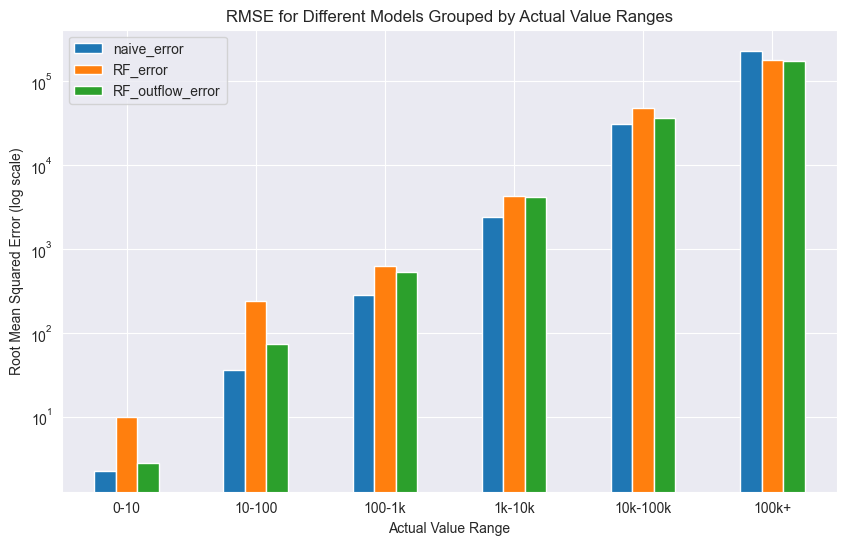

In [950]:
# Plot the bar plot
import seaborn as sns
sns.set_style('darkgrid')
grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error (log scale)')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
plt.yscale('log')
plt.legend()
plt.show()

In [936]:
# Calculate overall RMSE for each model
overall_rmse = {
    'Model': ['Naive', 'RF', 'RF_outflow'],
    'RMSE': [
        np.sqrt(mean_squared_error(outflow_pred['actual'], outflow_pred['naive'])),
        np.sqrt(mean_squared_error(outflow_pred['actual'], outflow_pred['RF'])),
        np.sqrt(mean_squared_error(outflow_pred['actual'], outflow_pred['RF_outflow']))
    ]
}

# Create DataFrame for overall RMSE
overall_rmse_df = pd.DataFrame(overall_rmse)

# Display the table
overall_rmse_df

,Model,RMSE
0,Naive,4593.956
1,RF,4570.256
2,RF_outflow,4717.330


Text(0, 0.5, 'Root Mean Squared Error')

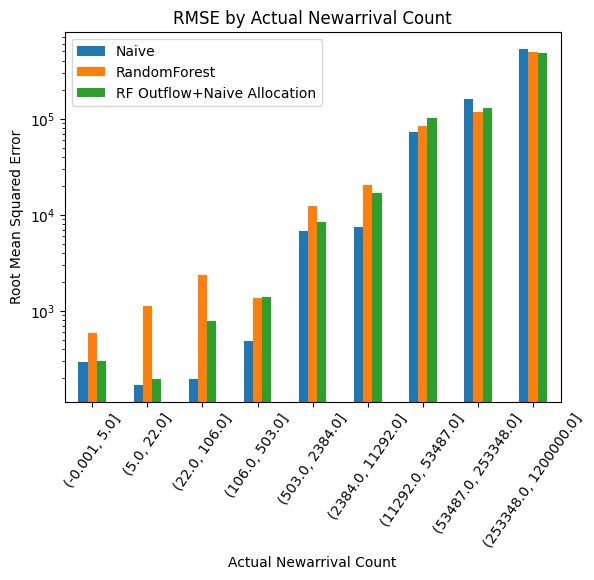

In [879]:
ax = pd.DataFrame({'Naive':naive_rmse.naive, 'RandomForest':rf_rmse.RF, 'RF Outflow+Naive Allocation':rf2_rmse.RF_outflow}).plot.bar(rot=55, title='RMSE by Actual Newarrival Count', logy=True)
ax.set_xlabel("Actual Newarrival Count")
ax.set_ylabel("Root Mean Squared Error")

In [868]:
pd.concat([rf_rmse, rf2_rmse, naive_rmse], axis=1).apply(lambda x: np.average(x, weights=outflow_pred.value_counts('bins'))).to_frame('RMSE')

,RMSE
RF,880.062
RF_outflow,531.920
naive,452.350


In [869]:
outflow_pred.rename({'newarrival':'naive'}, axis=1)[['naive','RF','RF_outflow']].apply(lambda x: mean_squared_error(outflow_pred['actual'], x, squared=False), axis=0).to_frame(name='RMSE')

,RMSE
naive,4593.956
RF,4570.256
RF_outflow,4717.330


In [838]:
mean_squared_error(outflow_pred['actual'], outflow_pred['RF'], squared=False)

4570.25601702379

In [760]:
outflow_pred.__len__()

152877

In [759]:
testt = pd.concat([data.newarrival.groupby('Id').shift(-1)[filter_multi_date(data, 'year','2017','>=') & filter_multi_date(data, 'year','2020','<=') & syria_filter_ ], data[filter_multi_date(data, 'year','2017','>=') & filter_multi_date(data, 'year','2020','<=') & syria_filter_].newarrival],axis=1)
testt.columns = ['actual','pred']
testt[filter_multi(testt, 'Id',['VENCOL'])]

,,actual,pred
year,Id,,
2017-01-01,VENCOL,1105410.000,575.000
2018-01-01,VENCOL,610164.000,1105410.000
2019-01-01,VENCOL,94765.000,610164.000
2020-01-01,VENCOL,128664.000,94765.000


In [742]:
syria_filter_ = ((filter_multi(data, 'Id',['SYRTUR']) & filter_multi_date(data, 'year','2018', '<=')) | ~filter_multi(data,'Id',['SYRTUR']))
mean_squared_error(data.newarrival.groupby('Id').shift(-1)[filter_multi_date(data, 'year','2017','>=') & filter_multi_date(data, 'year','2020','<=') & syria_filter_ ], data[filter_multi_date(data, 'year','2017','>=') & filter_multi_date(data, 'year','2020','<=') & syria_filter_].newarrival, squared=False)

4705.117578985655

Ok, the RF2 performs the worst. how about when just looking at outflows?

In [954]:
outflow_df = outflow_pred.rename({'newarrival':'naive','actual':'newarrival_t+1','pred':'RF','newarrival_y':'RF_outflow'},axis=1)

outflow_df['iso_o'] = outflow_df.Id.str[:3]
outflow_df = outflow_df.groupby(['year','iso_o']).agg({'naive':'sum','newarrival_t+1':'sum','RF':'sum','RF_outflow':'sum'})

In [955]:
outflow_df.drop(['newarrival_t+1','RF_outflow'],axis=1).merge(y_pred, right_index=True, left_index=True).apply(lambda x: mean_squared_error(outflow_df['newarrival_t+1'], x, squared=False)).to_frame(name='RMSE')

,RMSE
naive,106179.616
RF,112505.694
RF_outflow,106777.377


In [630]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
outflow_pred['abs_diff'] = np.round(np.abs(outflow_pred.RF_outflow - outflow_pred.actual),-1)
outflow_pred.sort_values(by='abs_diff', ascending=False).head()[['Id','year','actual','newarrival','RF','RF_outflow','abs_diff']]

,Id,year,actual,newarrival,RF,RF_outflow,abs_diff
146012,VENCOL,2017-01-01,1105410.000,575.000,931.750,558.822,1104850.000
90544,MMRBGD,2017-01-01,16252.000,655500.000,585703.540,966182.834,949930.000
146404,VENPER,2017-01-01,548114.000,33149.000,53433.840,32216.341,515900.000
146014,VENCOL,2019-01-01,94765.000,610164.000,401667.200,455352.609,360590.000
123836,SSDSDN,2017-01-01,99425.000,475547.000,396001.490,434091.378,334670.000
